# Traçage de réseaux de chaleur urbain

***Auteur : Charlotte Gressel, étudiante ingénieur à l'école des Mines, 2025***

Ce notebook permet, pour un quartier ou une ville sélectionnée, de déterminée les opportunités d'installation de réseau de chaleur urbain, et le tracer. Nous nous appuyerons sur les travaux de Nicolas Matte ayant fourni un algorythme de traçage du réseau optimal pour un lieu donné.

Nous proposerons, dans un second temps, une technique d'optimisation du réseau par réduction de sa longueur.

In [4]:
from shapely.geometry import shape, LineString, MultiLineString, Point, Polygon
from shapely.ops import nearest_points
import fiona
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import geopandas as gpd

## Extraction et filtrage des données géographiques et énergétiques

Dans cette partie, deux principaux fichiers sont à l'étude : 
- Un fichier des bâtiments pour un département choisi, téléchargé sur le site BD TOPO® de Géoservices (base BDNB) au format Geopackage
- Un fichier des routes pour un département choisi, téléchargé sur le site BD CARTO® de Géoservices au format Geopackage

Elles ont ensuite été exploités avec le logiciel GQIS afin d'extraire et exporter uniquement les attributs à étudier, à savoir `Bâtiments groupes > Classe DPE (DPE réels)` pour les bâtiments et `BDT_3-~1 — troncon_de_route` pour les routes. 

Il est important de souligner que l'étude est faite à partir de données **départementales** et non nationales, notamment pour des raisons de format des données téléchargeables et du temps de calcul. Le département choisi dans l'étude qui suit est l'Oise.

In [7]:
# Chemins vers les fichiers GeoPackage
buildings_file = "C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/test60/bat_oise.gpkg"
roads_file = "C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/test60/routes_oise.gpkg"

### Sélection de la zone d'étude

On commence par sélectionner le lieu que l'on souhaite étudier à partir de l'attribut `code_commune_insee`. 

**Attention!** Le `code_commune_insee` n'est pas le même que le code postal connu de tous. Il est donc nécessaire de rechercher sur le site de l'Insee le code commune de la zone à étudier.

In [10]:
# Demande du code postal de la ville/lieu à étudier

def ask_code_commune():
    while True:
        code_postal = input("Veuillez entrer le code postal de la commune que vous souhaitez étudier : ")
        
        # Validation simple : vérifier que le code postal contient exactement 5 chiffres
        if code_postal.isdigit() and len(code_postal) == 5:
            return code_postal
        else:
            print("Le code commune Insee doit contenir exactement 5 chiffres. Veuillez réessayer.")

def find_libelle_commune(code_commune):
    buildings_fiona = fiona.open(buildings_file)

    libelle_commune = None
    for building in buildings_fiona:
        building_properties = building["properties"]
        if building_properties["code_commune_insee"] == code_commune:
            libelle_commune = building_properties["libelle_commune_insee"]
            break  # On arrête dès qu'on trouve un match
    
    buildings_fiona.close()

    return libelle_commune

code_comm_insee = ask_code_commune()
libelle_commune = find_libelle_commune(code_comm_insee)

print(f"Code commune Insee retenu : {code_comm_insee}")
print(f"Commune sélectionnée : {libelle_commune}")

Veuillez entrer le code postal de la commune que vous souhaitez étudier :  60104


Code commune Insee retenu : 60104
Commune sélectionnée : Breteuil


### Sélection des bâtiments et des routes

#### 1<sup>er</sup> filtrage: sélection des bâtiments et des routes de la commune choisie

On commence par sélectionner les bâtiments de la commune choisie. Les bâtiments devront également répondre à un critère de hauteurs supérieur à 3 mètres. 

Cette opération est la plus chronophage en raison du nombre important de bâtiments à parcourir (390 581 ici).

In [14]:
# Extraction des bâtiments
buildings_fiona = fiona.open(buildings_file)

buildings = []  # bâtiments qui seront considérés pour le RCU

for building in tqdm(buildings_fiona, desc="Extraction des bâtiments", unit="bâtiment"):
    properties = building["properties"]
    
    # Vérification des conditions sur les propriétés
    if (properties["code_commune_insee"] == code_comm_insee and
        properties["s_geom_groupe"] is not None and
        properties["ffo_bat_annee_construction"] is not None and
        properties["bdtopo_bat_hauteur_mean"] is not None and
        properties["bdtopo_bat_hauteur_mean"] >= 3 and
        properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"] is not None and
        properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"] != "N"):
        buildings.append(building)

buildings_fiona.close()

print(len(buildings), "bâtiments ont été retenus.")

Extraction des bâtiments: 100%|████████████████████████████████████████| 390581/390581 [05:11<00:00, 1254.70bâtiment/s]

224 bâtiments ont été retenus.


On sélectionne ensuite les routes de la commune choisie grâce à la commune qui se trouve à droite et à gauche de la route. On ne conserve que les routes "intérieures", à savoir celles dont la commune à droite et à gauche est celle qui porte le code commune Insee sélectionné.

In [16]:
# Extraction des routes
roads_fiona = fiona.open(roads_file)

roads = []

distance_max = 50 

print("Analyse des routes en cours...")
for road in tqdm(roads_fiona, desc="Progression", unit="route"):
    properties = road["properties"]

    # Condition pour filtrer les routes
    if (properties["insee_commune_gauche"] == code_comm_insee) and \
       (properties["insee_commune_droite"] == code_comm_insee):
        
        roads.append(road)

# Fermeture du fichier et affichage des résultats
nb_roads = len(roads)
roads_fiona.close()

print(f"{nb_roads} routes ont été retenues.")

Analyse des routes en cours...


Progression: 100%|████████████████████████████████████████████████████████| 239444/239444 [02:39<00:00, 1500.57route/s]

677 routes ont été retenues.


Visualisons ce premier filtrage sur un graphe.

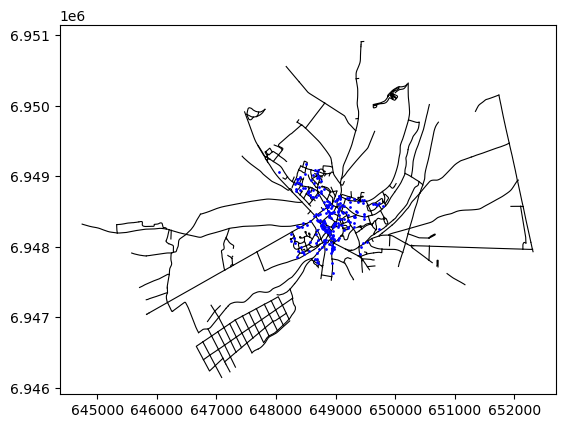

In [18]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x, y = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route
        plt.plot(x, y, color="black", linewidth=0.8)

# Représentation des bâtiments par des points
for building in buildings:
    polygon_batiment = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid = polygon_batiment.centroid
    plt.plot(centroid.x, centroid.y, 'bo', markersize=1)

#### 2<sup>ème</sup> filtrage : Sélection des bâtiments connectables


##### Calcul de la consommation des bâtiments et sélection du plus grand consommateur

Nous nous basons sur l'attribut `dpe_class_to_consumption` pour évaluer la consommation des bâtiments. La lettre attribuée à chaque bâtiment est associée à sa consommation énergétique moyenne en kWh/m²/an.

Nous estimons alors la consommation énergétique annuelle moyenne de chaque bâtiment à partir de leurs DPE moyen, surface et hauteur, par la formule suivante :

$$
Q \approx DPE \times S \times E\left(\frac{h}{h_0}\right)
$$

Où $h_0 = 3m$ et où $E$ est la fonction partie entière, afin d'introduire une estimation du nombre d'étages pour chaque bâtiment.

In [22]:
# Calcul des demandes en chaleur pour tous les bâtiments retenus

# Fonction de mapping de la classe DPE à la consommation énergétique (kWh/m²/an)
def dpe_class_to_consumption(dpe_class):
    dpe_map = {
        "A": 50,  # Consommation max pour A est 50
        "B": 90,  # Consommation max pour B est 90
        "C": 150, # Consommation max pour C est 150
        "D": 230, # Consommation max pour D est 230
        "E": 330, # Consommation max pour E est 330
        "F": 450, # Consommation max pour F est 450
        "G": 500  # On considère 500 comme une valeur représentative pour G (au-delà de 450)
    }
    return dpe_map[dpe_class]  # Pas besoin de valeur par défaut ici

# Calcul des demandes en chaleur pour tous les bâtiments retenus
h_0 = 3  # mètres, taille d'un étage
nb_buildings = len(buildings)
heat_demands = np.zeros(nb_buildings)

for k, building in enumerate(buildings):
    properties = building["properties"]
    
    # Conversion de la classe DPE en consommation d'énergie
    dpe_class = properties["dpe_mix_arrete_classe_conso_energie_arrete_2012"]  # Aucun défaut nécessaire
    dpe_consumption = dpe_class_to_consumption(dpe_class)
    
    # Calcul de la demande en chaleur en kWh/an
    Q = dpe_consumption * properties["s_geom_groupe"] * int(properties["bdtopo_bat_hauteur_mean"] / h_0)
    heat_demands[k] = Q

# Tri suivant les consommations décroissantes
sorted_index = np.argsort(heat_demands)[::-1]
heat_demands = np.sort(heat_demands)[::-1]
buildings = [buildings[index] for index in sorted_index]

Nous basons notre étude sur plusieurs principes : 
* Il y a une seule centrale de production par zone étudiée.
* On ne prend pas en compte la localisation de cette centrale, car on considère que la connecter au réseau ne nécessite qu'une centaine de mètres d'ajout de cannalisations, négligeable devant la longueur totale du réseau.
* La capacité de production de chaleur est supposée sans limite.

Dans cette étude, **nous ferons le choix arbitraire de démarrer notre algorythme de traçage du bâtiment le plus consommateur en énergie**. 

Il s'agit dès un présent de sélectionner ce dernier, qui est le premier de la liste en raison du tri précédent.

##### Détermination des bâtiments connectables

Choisir les bâtiments qui seront raccordés au réseau de chaleur n'est pas un problème à solution absolue ni unique. Il faut prendre en compte une multitude de paramètres :
* Budget de la mairie
* Offre en chaleur disponible
* Consommation des bâtiments : est-il rentable de les raccorder ?
* Carbonation de la chaleur actuellement distribuée aux bâtiments
* Objectifs de la municipalité, pression d'autres acteurs...

L'agent municipal peut ainsi éliminer à la main certains groupes de bâtiments, mais il peut également se fier à certains critères de priorité pour le raccordement, notamment la demande en chaleur. En effet, pour avoir un réel impact et augmenter sa rentabilité, le réseau de chaleur doit pouvoir subvenir à la plus grande demande en chaleur possible avec une taille minimale.

Ainsi, la méthode que nous proposons en tant qu'agent municipal est la suivante :
1. Eliminer ou inclure d'office certains groupes de bâtiments à la main;
2. Déterminer un critère de consommation minimale pour définir le reste des bâtiments connectables;

##### 1. Eliminer ou inclure d'office certains groupes de bâtiments à la main

L'agent municipal doit parfois suivre certaines directives stratégiques, par exemple raccorder certains groupes de bâtiments prioritaires ou bien le tertiaire qui participe au financement du projet. Il peut également avoir conscience de certaines choses non prises en compte par l'ordinateur : certains bâtiments seront bientôt détruits, d'autres bientôt construits, certains sont déjà connectés à d'autres infrastructures performantes...  

On pourrait modéliser les décisions de l'agent municipal par deux liste d'indices `eliminated_index` et `imposed_index` qui correspondent respectivement aux bâtiments éliminés et raccordés d'office par l'agent municipal. Dans ce notebook, dans le but d'illustrer les résultats de l'algorithme, nous supposerons ces listes vides.

##### 2. Déterminer un critère de consommation minimale pour définir le reste des bâtiments connectables

Un tel critère est défini sur le site **France Chaleur** : au-delà de $30kW$, un bâtiment doit dans la plupart des cas être considéré pour le tracé du réseau de chaleur.

La puissance thermique maximale demandée par les habitations est estimée grâce à une technique définie dans la section suivante. On réalisera alors le filtrage des bâtiments selon ce critère.

Ce procédé permet de trouver le compromis entre une demande raccordée maximale en premier plan et un nombre de bâtiments raccordé minimal afin de limiter les coûts.

##### Sélection des bâtiments les plus demandeurs

Un critère pour labelliser un réseau de chaleur urbain est de raccorder systématiquement les bâtiments ayant une demande en puissance maximale supérieure à 30kW. Pour cela, la première étape est d'estimer leurs consommations thermiques annuelles. Le procédé est le même que dans le notebook précédent.

##### Estimation de la consommation énergétique annuelle moyenne

Afin de réaliser la simulation d'un réseau de chaleur avec le logiciel Dymola, il faut estimer leurs demandes instantanées tout au long de l'année. Pour cela, nous utilisons la méthode décrite dans les sections suivantes.

Nous utilisons des profils typiques de demande en chaleur. Nous disposons de trois fichiers correspondant aux courbes typiques des bâtiments construits durant les périodes suivantes :
* Avant 1989 (exclu) : `RT_1974_Treated.csv` (il s'agit en réalité des normes des bâtiments construits entre 1974 et 1989);
* Entre 1989 (inclus) et 2005 (exclu) : `RT_1989_Trated.csv` (il s'agit des normes des bâtiments construits entre 1989 et 2005);
* Après 2005 (inclus) : `RT_2005_Treated.csv`.

Il s'agit de timeseries que nous allons manipuler avec `pandas`.

In [35]:
heat_profile_1974 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/code/data/RT_1974_Treated.csv", index_col=0)
heat_profile_1989 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/code/data/RT_1989_Treated.csv", index_col=0)
heat_profile_2005 = pd.read_csv("C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/code/data/RT_2005_Treated.csv", index_col=0)

On calcule ensuite la puissance thermique demandée pour chaque bâtiment à partir de la formule suivante:
$$
\Phi_{th} = D_m \cdot c_p \cdot (T_{départ} - T_{retour})
$$

Puis on calcule le coefficient de demande en chaleur associé à chaque bâtiment:
$$
\alpha_k = \frac{Q_{total}}{\left( \sum_{1 \, \text{an}} \Phi_{th,ref} \right) \cdot \Delta t}
$$


In [37]:
# Tableau des coefficients alpha
heat_profile_coeff_tab = np.zeros(nb_buildings)

# Constantes
cp_water = 4180 # J/K/kg
delta_t = 1 # h (l'énergie est en kWh)

# Initialisation
sum_power = np.zeros(3)

# Fonction pour catégoriser les bâtiments suivant leur année de construction
def categorize(building):
    construction_date = building["properties"]["ffo_bat_annee_construction"]
    # 0 : avant 1989 exclu
    if construction_date < 1989:
        return 0
    # 1 : entre 1989 inclus et 2005 exclu
    elif 1989 <= construction_date < 2005:
        return 1
    # 2 : après 2005 exclu
    else:
        return 2
    
df_tab = [heat_profile_1974, heat_profile_1989, heat_profile_2005]

# Calcul de la colonne des puissances dans les dataframes de référence
def add_power_column(df):
    df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)
    
for k, df in enumerate([heat_profile_1974, heat_profile_1989, heat_profile_2005]):
    # Ajout de la colonne puissance
    add_power_column(df)
    # Calcul de la somme des puissances
    sum_power[k] = df.Puissance.sum()

# Calcul des coefficients pour chaque bâtiment hors usine à chaleur
for k, building in enumerate(buildings):
    category = categorize(building)
    heat_profile_coeff_tab[k] = heat_demands[k] / (delta_t * sum_power[category] * 1e-3) # attention unités : kWh / kWh

C:\Users\charl\AppData\Local\Temp\ipykernel_11892\3192598625.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)


On ne conserve que les bâtiments dont la puissance maximale demandée excède $30kW$.

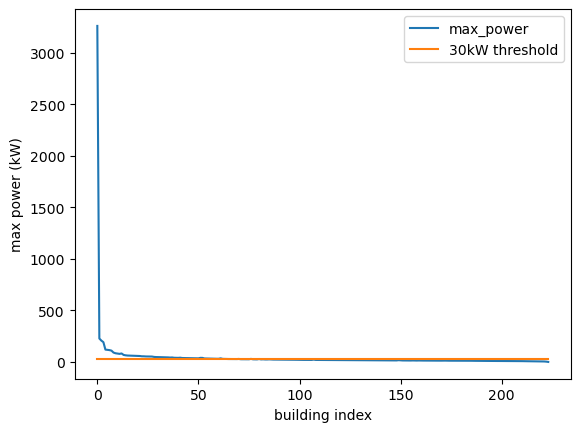

In [39]:
# Tableau du max des puissances pour chaque bâtiment
max_power = np.zeros(nb_buildings)
for k, building in enumerate(buildings):
    max_power[k] = heat_profile_coeff_tab[k] * np.max(df_tab[categorize(building)].Puissance)
plt.plot(max_power*1e-3, label="max_power")
plt.plot([30 for _ in range(nb_buildings)], label="30kW threshold")
plt.xlabel("building index")
plt.ylabel("max power (kW)")
plt.legend();

In [40]:
mask = np.array([power > 30e3 for power in max_power])
buildings = [buildings[k] for k in range(nb_buildings) if mask[k]]
nb_buildings = len(buildings)
print("Nombre de bâtiments sélectionnés après le deuxième filtrage :", nb_buildings)

Nombre de bâtiments sélectionnés après le deuxième filtrage : 64


In [41]:
# Plus grand consommateur
highest_demand = buildings[0]

### Visualisation du quartier d'intérêt

Nous pouvons enfin visualiser le quartier d'intérêt après tous les filtrages nécessaires :

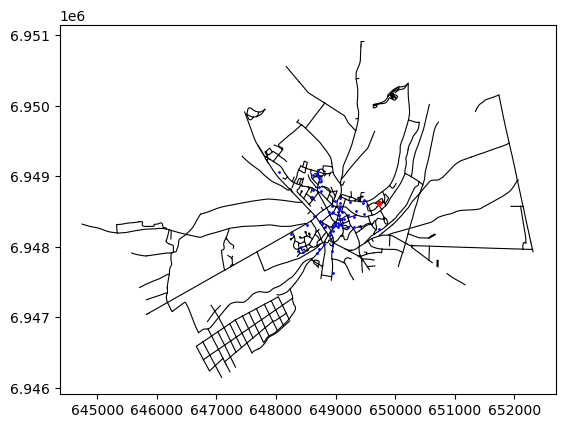

In [44]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées

    coordinates = [coordinates]  # Transformer en liste pour itération uniforme

    for segment in coordinates:  # Itérer sur chaque segment de la route
        # Extraire les coordonnées (gérer 2D ou 3D)
        x_ligne1, y_ligne1 = zip(*[(x, y) for x, y, z in segment])
        
        # Tracé du segment de la route
        plt.plot(x_ligne1, y_ligne1, color="black", linewidth=0.8)

# Représentation des bâtiments par des points
for building in buildings:
    polygon_batiment = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid = polygon_batiment.centroid
    plt.plot(centroid.x, centroid.y, 'bo', markersize=1)

# Représentation de l'usine à chaleur
polygon_plant = shape(highest_demand["geometry"])
centroid_x, centroid_y = polygon_plant.centroid.xy
plt.plot(centroid_x, centroid_y, "ro", markersize=3);

Légende :
* Ligne noire: route
* Point bleu: bâtiment
* Point rouge: bâtiment le plus consommateur

## Modélisation du quartier par un graphe

### Définition des noeuds

On définit deux types de noeuds qui possédent de nombreuses propriétés de trois types : topologiques, énergétiques et relatives au réseau de chaleur. On compte comme type de noeud :
* Les bâtiments
* Les routes
* Le plus grand consommateur

Une telle représentation permet de grandement simplifier l'écriture du code.

In [49]:
lambda_ = 1.5e3 # kWh/m/an

class Node_building:
    # Un bâtiment sera représenté par un indice et l'objet bâtiment qui y est associé
    def __init__(self, index):
        self.index = index
        self.building = buildings[index]
        self.coordinates = self.building["geometry"]["coordinates"][0][0]
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "batiment"
        self.predecessor = None
        properties = self.building["properties"]
        self.heat_demand = heat_demands[index]
        self.radius = self.heat_demand / lambda_
        self.construction_date = properties["ffo_bat_annee_construction"]
        self.heat_profile_coeff = heat_profile_coeff_tab[index]

class Node_road:
    def __init__(self, index):
        self.index = index
        self.road = roads[index]

        # Récupérer les coordonnées brutes
        raw_coordinates = self.road["geometry"]["coordinates"]

        # Vérifier si c'est une structure 2D ou 3D, ou un type inattendu
        if isinstance(raw_coordinates[0], (list, tuple)):
            self.coordinates = [
                (coord[0], coord[1]) if len(coord) >= 2 else (coord[0], 0)
                for coord in raw_coordinates
                if isinstance(coord, (list, tuple))  # Vérifie que coord est une liste ou un tuple
            ]
        else:
            # Si la structure est une seule ligne
            self.coordinates = [
                (raw_coordinates[0], raw_coordinates[1]) if len(raw_coordinates) >= 2 else (raw_coordinates[0], 0)
            ]

        # Vérifier si des coordonnées valides ont été trouvées
        if not self.coordinates:
            raise ValueError(f"Aucune coordonnée valide trouvée pour la route à l'index {index}. "
                             f"Données initiales : {self.road['geometry']['coordinates']}")

        # Calcul du centre
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "route"

        self.predecessor = None
        self.length = shape(self.road["geometry"]).length

class Node_plant:
    # L'usine à chaleur sera représenté par un indice et l'objet bâtiment qui y est associée
    # Différence avec les noeuds bâtiments : ni demande en chaleur ni rayon caractéristique, index = nb_buildings pour le distinguer et ce sera le dernier dans les listes
    def __init__(self, highest_demand=highest_demand):
        self.index = nb_buildings
        self.building = highest_demand
        self.coordinates = highest_demand["geometry"]["coordinates"][0][0]
        x, y = zip(*self.coordinates)
        self.center = (np.mean(x), np.mean(y))
        self.type = "Plus grand consommateur"
        self.predecessor = None

### Modélisation des arêtes

La présence d'une arête entre deux noeuds signifie qu'un tuyau peut joindre directement ces derniers en suivant la route et sans croiser de noeud intermédiaire. Il y a ainsi deux types de noeuds :
* Entre deux tronçons de routes successifs;
* Entre un bâtiment et une route qui lui est proche.

Nous avons fait le choix de ne raccorder que depuis la route les bâtiments, on exclut donc la possibilité de réaliser des tuyaux entre les habitations. Il y aura donc éventuellement une légère surestimation du coût du réseau de chaleur qu'il faudra prendre en compte lors de la présentation du projet.

Les arêtes seront modélisées par des tables d'adjacence représentées par des dictionnaires Python. Il s'agit certes de structures redondantes, mais nous les avons choisi pour leur grande efficacité en terme de temps de calcul. L'encombrement mémoire ne représentera par ailleurs pas un problème étant donnée la faible taille du graphe étudié (de l'odre du millier de noeuds).

### Construction du graphe

Les règles sont les suivantes pour calculer les arêtes :
1. Deux routes sont connectées si et seulement si la distance minimale entre ces dernières est inférieure à 5m;
2. Un bâtiment est connecté à sa route la plus proche.

In [70]:
# Liste des noeuds bâtiments
list_nodes_buildings = [Node_building(index) for index in range(0, nb_buildings)] + [Node_plant(highest_demand)]
# Liste des noeuds routes
list_nodes_roads = [Node_road(index) for index in range(nb_roads)]
# Liste des arêtes entre les routes initialisée vide
list_edges_roads = {road.index : [] for road in list_nodes_roads}
# Liste des arêtes entre routes et bâtiments initialisée vide
list_edges_buildings = {building.index : [] for building in list_nodes_buildings}
# Liste des arêtes entre routes et bâtiments, mais dans l'autre sens
list_edges_roads_buildings = {road.index : [] for road in list_nodes_roads}


# Relier les routes entre elles à 5m près
for road1 in list_nodes_roads:
    for road2 in list_nodes_roads[road1.index+1:]:
        if road2 != road1:
            line1 = LineString(road1.coordinates)
            line2 = LineString(road2.coordinates)
    
            # On relie si cette distance est inférieure à 5m
            if line1.distance(line2) <= 5:
                list_edges_roads[road1.index].append(road2)
                list_edges_roads[road2.index].append(road1)
            
# Relier les bâtiments et l'usine à chaleur à la route la moins éloignée
for building in list_nodes_buildings:
    is_connected = False
    closest_road = list_nodes_roads[0]
    closest_road_distance = 10000
    for road in list_nodes_roads:

        point1 = Point(building.center)
        line2 = LineString(road.coordinates)

        # Calculer la distance minimale entre le bâtiment et la route
        minimal_distance = point1.distance(line2)

        if minimal_distance < closest_road_distance:
            closest_road_distance = minimal_distance
            closest_road = road
        
    # On connecte à la route la plus proche
    list_edges_buildings[building.index].append((closest_road, closest_road_distance))
    list_edges_roads_buildings[closest_road.index].append((building, closest_road_distance))

In [ ]:
# Construction du graphe

# Liste des noeuds bâtiments
list_nodes_buildings = [Node_building(index) for index in range(0, nb_buildings)] + [Node_plant(highest_demand)]
# Liste des noeuds routes
list_nodes_roads = [Node_road(index) for index in range(nb_roads)]
# Liste des arêtes entre les routes initialisée vide
list_edges_roads = {road.index : [] for road in list_nodes_roads}
# Liste des arêtes entre routes et bâtiments initialisée vide
list_edges_buildings = {building.index : [] for building in list_nodes_buildings}
# Liste des arêtes entre routes et bâtiments, mais dans l'autre sens
list_edges_roads_buildings = {road.index : [] for road in list_nodes_roads}

# Relier les routes entre elles à 5m près
for road1 in list_nodes_roads:
    for road2 in list_nodes_roads[road1.index+1:]:

        line1 = LineString(road1.coordinates)
        line2 = LineString(road2.coordinates)

        # Calculer la distance minimale entre les deux routes
        minimal_distance = line1.distance(line2)

        # On relie si cette distance est inférieure à 5m
        if minimal_distance <= 5:
            list_edges_roads[road1.index].append(road2)
            list_edges_roads[road2.index].append(road1)
            
# Relier les bâtiments et l'usine à chaleur à la route la moins éloignée
for building in (list_nodes_buildings):
    is_connected = False
    closest_road = list_nodes_roads[0]
    closest_road_distance = 10000
    for road in list_nodes_roads:

        line1 = LineString(building.coordinates)
        line2 = LineString(road.coordinates)

        # Calculer la distance minimale entre le bâtiment et la route
        minimal_distance = line1.distance(line2)

        if minimal_distance < closest_road_distance:
            closest_road_distance = minimal_distance
            closest_road = road
    
    # On connecte à la route la plus proche
    list_edges_buildings[building.index].append((closest_road, closest_road_distance))
    list_edges_roads_buildings[closest_road.index].append((building, closest_road_distance))
    is_connected = True # Ligne inutile mais facilite la lecture

### Visualisation du graphe

Il est important de visualiser régulièrement ce que l'on fait afin d'éviter toute aberration.

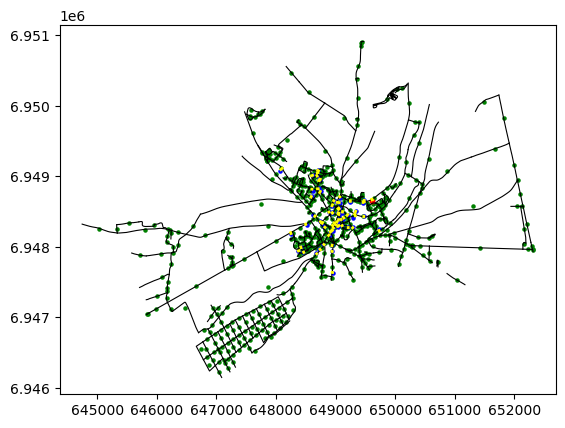

In [71]:
# Représentation graphique - batiments en rouge, routes en bleu (points), le tout relié. Si c'est assez lisible,
# on ajoutera dans un second temps le tracé des routes

# Tracé des routes et positionnement des noeuds de route
for road in list_nodes_roads:
    # Tracé des routes
    x_line1, y_line1 = zip(*road.coordinates)
    plt.plot(x_line1, y_line1, color="black", linewidth=0.8)
    # Positionnement des noeuds de route
    plt.scatter(road.center[0], road.center[1], color="green", s=5)

# Arêtes entre routes et bâtiments
for building in list_nodes_buildings:
    edges = list_edges_buildings[building.index]
    building = list_nodes_buildings[building.index]
    for road, _ in edges:
        geom1 = shape(building.building["geometry"])
        geom2 = shape(road.road["geometry"])
        nearest_points_obj1_to_obj2 = nearest_points(geom1, geom2)

        # Extraire les coordonnées des points les plus proches
        x_coords = [point.x for point in nearest_points_obj1_to_obj2]
        y_coords = [point.y for point in nearest_points_obj1_to_obj2]

        # Tracer la ligne reliant les deux points
        plt.plot(x_coords, y_coords, color='yellow', linewidth=2)

# Positionnement des noeuds de bâtiments
for building in list_nodes_buildings:
    if building.type == "Plus grand consommateur":
        plt.scatter(building.center[0], building.center[1], color="red", s=10)
    else:
        plt.scatter(building.center[0], building.center[1], color="blue", s=5)

Légende :
* Point bleu : noeud de bâtiment
* Point vert : noeud de route
* Point rouge : noeud d'usine à chaleur
* Ligne noire : route réelle
* Ligne jaune : plus petit chemin entre un bâtiment et sa route la plus proche

Il faut avoir conscience du fait que, bien que l'on prenne en compte dans les calculs les formes des bâtiments, ces dernières ne sont ici pas représentées. Ainsi, les points que l'on observe sont situés au niveau du barycentre de chaque noeud (bâtiment comme route).

## Implémentation de l'algorithme de tracé

Tout est codé dans la classe `Graph` implémentée ci-dessous. Quelques points pour décrire les outils implémentés :
* Le réseau de chaleur est initialisé au seul noeud de production
* Le critère de raccordabilité est toujours vérifié et mis à jour
* La connexion entre deux bâtiments est effectuée en suivant le plus court chemin dans un espace métrique où l'on suit les routes et où les routes déjà traversées par le réseau sont de longueurs nulles (les distances sont donc actualisées dynamiquement).

In [76]:
class Graph:

    def __init__(self, list_nodes_buildings, list_nodes_roads, list_edges_buildings, list_edges_roads, list_edges_roads_buildings):
        self.list_nodes_buildings = list_nodes_buildings
        self.list_nodes_roads = list_nodes_roads
        self.list_edges_buildings = list_edges_buildings
        self.list_edges_roads = list_edges_roads
        self.list_edges_roads_buildings = list_edges_roads_buildings
        self.nb_buildings = len(self.list_nodes_buildings) - 1
        self.nb_roads = len(self.list_nodes_roads)
        self.dhn_roads = np.full(self.nb_roads, False) # DHN : district heat network
        self.dhn_buildings = np.full(self.nb_buildings, False)
        self.radii = np.zeros(nb_buildings)
        self.network_radius = 0
        self.loop_test = False

    def initialise_radii(self):
        """
        Réinitialise la liste interne au graphe aux valeurs des rayons des bâtiments
        """
        for building in self.list_nodes_buildings[:-1]:
            self.radii[building.index] = building.radius

    def connect_network(self, building, verbose=False):
        """
        Connecte building depuis l'usine à chaleur en remontant le plus court chemin
        grâce aux prédecesseurs (calculés en amont de cette fonction avec shortest_way !)
        """
        if verbose:
            print("Connexion au réseau du bâtiment :", building.index)
        # Indiquer le bâtiment comme connecté
        self.dhn_buildings[building.index] = True
        # Trouver la rue connectée à building située sur le plus court chemin entre building et l'usine à chaleur
        node = building.predecessor
        while node.type != "Plus grand consommateur":
            if node.type == 'route':
                if verbose and not self.dhn_roads[node.index]:
                    print("Connexion de la route", node.index)
                # On remonte le plus court chemin jusqu'à revenir à building
                self.dhn_roads[node.index] = True
            node = node.predecessor

    def reinitialise_predecessors(self):
        """
        Réinitialise les attributs 'predecessor' de tous les noeuds
        """
        for building in self.list_nodes_buildings:
            building.predecessor = None
        

    def shortest_way(self, initial_builing, list_buildings, verbose=False):
        """
        Calcule les plus petits chemins entre initial_building et les éléments
        de liste_building
        """
        verbose = False
        # Algorithme de Djikstra, termine lorsque les batiments de liste_batiments ont été parcourus
        if verbose:
            print("Calcul du plus court chemin depuis le batiment numéro:", initial_builing.index)
        # Réinitialisation des prédecesseurs
        self.reinitialise_predecessors()
        # Initialisation
        list_index = [building.index for building in list_buildings]
        distances_buildings = np.full(self.nb_buildings + 1, np.inf)
        distances_roads = np.full(self.nb_roads, np.inf)
        buildings_to_cross = np.full(self.nb_buildings + 1, True)
        roads_to_cross = np.full(self.nb_roads, True)
        
        distances_buildings[initial_builing.index] = 0

        # Itérations - tant que les batiments de list_buildings n'ont pas tous été parcourus
        while np.any(buildings_to_cross[list_index]):
            # Nous allons calculer le noeud de plus petite distance en comparant celui de type Node_building et celui de type Node_road (tous deux de plus petite distance par rapport à leurs semblables)

            # Il reste nécessairement des noeuds de bâtiments à parcourir
            # On choisit le noeud non parcouru de plus petite distance de type bâtiment
            mask_buildings = buildings_to_cross & (distances_buildings == np.min(distances_buildings[buildings_to_cross])) # tableau de booléens dont les composantes valent True ssi le bâtiment n'a pas été parcouru et est de plus petite distance
            index_building = np.argmax(mask_buildings) # Calcule l'indice de la première occurence de True dans le tableau précédent
            # On stocke la distance correspondante
            minimal_distance_buildings = distances_buildings[index_building] 

            # S'il reste des noeuds de routes à parcourir
            if np.any(roads_to_cross):
                # On choisit le noeud non parcouru de plus petite distance de type route
                mask_roads = roads_to_cross & (distances_roads == np.min(distances_roads[roads_to_cross]))
                index_road = np.argmax(mask_roads)
                minimal_distance_roads = distances_roads[index_road]
                # test = "Le noeud non parcouru de plus petite distance est-il un bâtiment ?"
                test = minimal_distance_buildings <= minimal_distance_roads
            # S'il n'y a plus de routes à parcourir, alors on dit que test est vrai pour parcourir le noeud bâtiment de plus petite distance
            else :
                test = True
            
            # CAS 1 : le noeud de plus petite distance est un bâtiment
            if test:
                # current_building est le bâtiment correspondant à cette distance
                current_building = self.list_nodes_buildings[index_building]
                # On l'indique comme parcouru
                buildings_to_cross[index_building] = False
                if verbose:
                    print("Batiment actuel :", index_building)
                # On parcourt les noeuds voisins non parcourus (routes)
                for road, length in self.list_edges_buildings[index_building]:
                    # On teste si le noeud n'a pas été parcouru
                    if roads_to_cross[road.index]:
                        # Minimisation du chemin
                        new_distance = distances_buildings[index_building] + length
                        if distances_roads[road.index] > new_distance:
                            distances_roads[road.index] = new_distance
                            road.predecessor = current_building
            
            # CAS 2 : le noeud de plus petite distance est une route
            else:
                # current_road est la route correspondant à cette distance
                current_road = self.list_nodes_roads[index_road]
                # On l'indique comme parcourue
                roads_to_cross[index_road] = False
                if verbose:
                    print("Route actuelle :", index_road)
                # On détermine la longueur de tuyaux à ajouter sur la route actuelle
                if self.dhn_roads[current_road.index]:
                    length_road = 0
                else:
                    length_road = current_road.length
                # On parcourt les routes voisines non parcourues
                for road in self.list_edges_roads[index_road]:
                    if roads_to_cross[road.index]:
                        # Minimisation du chemin
                        new_distance = distances_roads[index_road] + length_road
                        if distances_roads[road.index] > new_distance:
                            distances_roads[road.index] = new_distance
                            road.predecessor = current_road
                # On parcourt les batiments voisins non parcourus
                for building, length in self.list_edges_roads_buildings[index_road]:
                    if buildings_to_cross[building.index]:
                        # Minimisation du chemin
                        new_distance = distances_roads[index_road] + length + length_road
                        if distances_buildings[building.index] > new_distance:
                            distances_buildings[building.index] = new_distance
                            building.predecessor = current_road
            
        return { list_index[k] : distances_buildings[building.index] for k in range(len(list_index)) }
      
            
    def compute_dhn(self, verbose=False):
        """
        Calcule le tracé du réseau de chaleur urbain
        """
        # Initialisation de la file de parcours des bâtiments, dans l'ordre de la conso énergétique décroissante
        self.queue = list(np.arange(self.nb_buildings))
        # Initialisation d'une liste pour savoir quels bâtiments ont déjà été parcourus
        self.were_crossed_buildings = np.full(self.nb_buildings, 0)
        # Réinitialisation des rayons
        self.initialise_radii()
        self.network_radius = 0
        # Réinitialisation du réseau de chaleur
        self.dhn_buildings = np.full(self.nb_buildings + 1, False)
        self.dhn_roads = np.full(self.nb_roads, False)
        # Le réseau est initialisé au noeud du plus grand consommateur
        self.dhn_buildings[-1] = True
        # On parcourt tous les bâtiments (hors usine à chaleur)
        while len(self.queue) > 0:
            # On prend le premier bâtiment dans la file d'attente
            index = self.queue[0]
            if verbose:
                print("Tentative de connexion du bâtiment :", index)
            current_building = self.list_nodes_buildings[index]
            # Calcule sa distance au réseau de chaleur
            distance_network = self.shortest_way(self.list_nodes_buildings[-1], [current_building], verbose=verbose)[index]
            # Si le raccord est économiquement viable, on l'effectue
            if self.radii[index] + self.network_radius >= distance_network:
                # Raccord
                self.connect_network(current_building, verbose=verbose)
                # Actualisation du rayon du réseau de chaleur
                self.network_radius += self.radii[index] - distance_network
                # On indique que le dernier bâtiment a avoir été raccordé l'a été après x tentatives
                self.loop_test = self.were_crossed_buildings[index]
            # Sinon, on remet le bâtiment au fond de la file à condition qu'un bâtiment a été connecté lors de la dernière boucle
            elif self.loop_test >= self.were_crossed_buildings[index] - 1:
                # Ajout à la file
                self.queue.append(index)
                # On indique que le bâtiment a été parcouru une fois de plus
                self.were_crossed_buildings[index] += 1
            # Dernier cas, le bâtiment ne sera pas raccordé au réseau
            else:
                pass
            # On retire current_building de la file
            self.queue.pop(0)

## Application de l'algorithme - tracé du réseau de chaleur

In [78]:
G = Graph(list_nodes_buildings, list_nodes_roads, list_edges_buildings, list_edges_roads, list_edges_roads_buildings)
G.compute_dhn(verbose=True)

Tentative de connexion du bâtiment : 0
Connexion au réseau du bâtiment : 0
Connexion de la route 249
Tentative de connexion du bâtiment : 1
Connexion au réseau du bâtiment : 1
Connexion de la route 471
Connexion de la route 472
Connexion de la route 473
Connexion de la route 469
Connexion de la route 602
Connexion de la route 605
Connexion de la route 616
Connexion de la route 606
Connexion de la route 609
Connexion de la route 608
Connexion de la route 536
Connexion de la route 589
Connexion de la route 570
Connexion de la route 566
Connexion de la route 567
Connexion de la route 569
Connexion de la route 571
Connexion de la route 564
Tentative de connexion du bâtiment : 2
Connexion au réseau du bâtiment : 2
Connexion de la route 618
Connexion de la route 615
Tentative de connexion du bâtiment : 3
Connexion au réseau du bâtiment : 3
Connexion de la route 621
Connexion de la route 612
Connexion de la route 619
Connexion de la route 604
Connexion de la route 611
Connexion de la route 61

[]

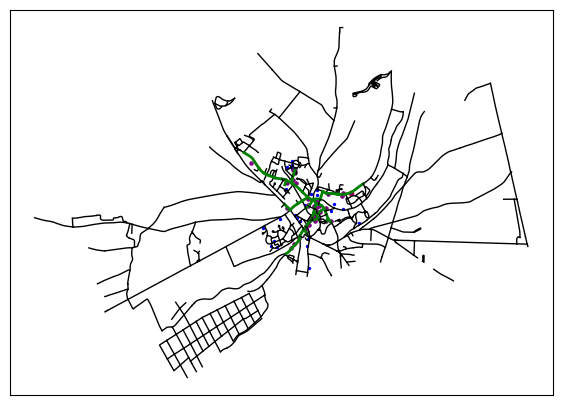

In [126]:
# Affichage du RCU

plt.figure(figsize=(7, 5))

# Affichage de tous les bâtiments
for building in G.list_nodes_buildings:
    if building.type == "Plus grand consommateur":
        plt.scatter(building.center[0], building.center[1], color="red", s=10)
    else:
        plt.scatter(building.center[0], building.center[1], color="blue", s=2)

# Arêtes entre routes et bâtiments
for index in range(G.nb_buildings+1):
    if G.dhn_buildings[index]:
        edges = list_edges_buildings[index]
        building = list_nodes_buildings[index]
        # Coloration en violet du bâtiment, sauf pour l'usine à chaleur
        if index < G.nb_buildings:
            x1, y1 = building.center
            plt.scatter(x1, y1, color="purple", s=5)
        for road, _ in edges:
            geom1 = shape(building.building["geometry"])
            geom2 = shape(road.road["geometry"])
            nearest_points_obj1_to_obj2 = nearest_points(geom1, geom2)


# Coloration des routes connectées
for road in G.list_nodes_roads:
    if G.dhn_roads[road.index]:
        color = "green"
        linewidth=2
    else:
        color = "black"
        linewidth=1
    x_ligne1, y_ligne1 = zip(*road.coordinates)
    plt.plot(x_ligne1, y_ligne1, color=color, linewidth=linewidth)

plt.gca().set_xticks([]) 
plt.gca().set_yticks([])

Légende :
* Point violet : bâtiment raccordé
* Point bleu : bâtiment non raccordé
* Point rouge : bâtiment plus grand consommateur
* Ligne verte : route raccordée
* Ligne noire : route non raccordée
* Ligne jaune : tuyaux entre une route et un bâtiment

## Analyse du RCU créé

On extrait le réseau de chaleur tracé pour pouvoir analyser sa longueur et la demande en chaleur qu'il couvre.

**Extraction des routes :**

In [84]:
connected_routes = []  
    
for road in G.list_nodes_roads:
    if G.dhn_roads[road.index]: # Si la route est connectée
        x_coords, y_coords = zip(*road.coordinates)
        connected_routes.append(LineString(zip(x_coords, y_coords)))

**Extraction des bâtiments :**

In [86]:
connected_buildings = []  

for index in range(G.nb_buildings):  # Parcourt tous les bâtiments sauf l'usine
    if G.dhn_buildings[index]:  # Si le bâtiment est connecté
        building = list_nodes_buildings[index]  
        building_info = {
            "index": building.index,              # Index du bâtiment
            "geometry": building.building["geometry"],  # Géométrie du bâtiment
            "center": building.center,            # Coordonnées du centre
            "heat_demand": building.heat_demand   # Demande de chaleur du bâtiment
        }
        connected_buildings.append(building_info)  

In [112]:
len(connected_buildings)

38

**Affichage du réseau tracé :**

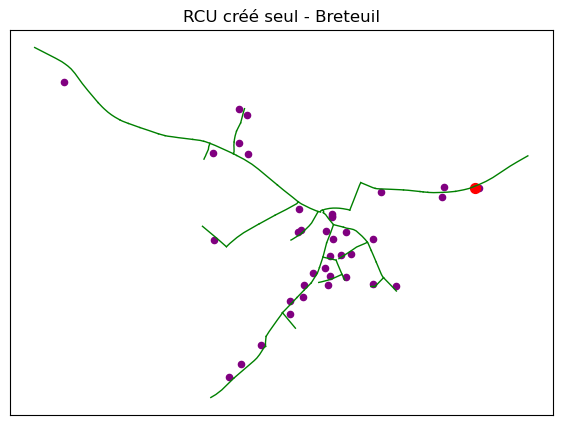

In [114]:
import matplotlib.pyplot as plt
from shapely.geometry import Point

plt.figure(figsize=(7, 5))  # Ajuste la taille pour un format vertical

for route in connected_routes:
    x, y = zip(*route.coords)  # Séparation des coordonnées x et y
    plt.plot(x, y, color="green", linewidth=1, label="Routes connectées")  # Tracé en vert pour les routes connectées

# Tracé des nœuds créés (en bleu)
for building in connected_buildings:
    x, y = building["center"]  # Coordonnées extraites du champ 'center'
    plt.scatter(x, y, color="purple", s=20, label="Bâtiments connectés")

heat_plant_coords = Point(highest_demand["geometry"]["coordinates"][0][0][0])
plt.scatter(heat_plant_coords.x, heat_plant_coords.y, color="red", s=50, label="Plus grand consommateur")

plt.title(f"RCU créé seul - {libelle_commune}")
plt.gca().set_xticks([]) 
plt.gca().set_yticks([])
plt.show()


On calcule alors la longueur totale du réseau tracé, en kilomètres.

In [90]:
def get_total_dhn_length(connected_routes):
    total_length = 0

    for route in connected_routes:
        # Créer une ligne à partir des coordonnées du tronçon
        line = LineString(route)
        
        # Ajouter la longueur du tronçon à la longueur totale
        total_length += line.length

    return total_length

dhn_length = get_total_dhn_length(connected_routes)/1000
print(f"Longueur totale du RCU créé : {dhn_length:.2f} km")

Longueur totale du RCU créé : 4.79 km


<u>Remarque</u> : Nous négligeons, dans la valeur ci-dessus, la longueur des pipes pour connecter l'usine à chaleur au réseau - estimée à une centaine de mètres maximum et donc négligeable.

Puis on calcule la demande en chaleur couverte par le réseau de chaleur, en GWh.

In [93]:
def get_dhn_heat_demand(connected_buildings):
    total_demand = 0  # Initialisation de la consommation totale
    
    for building in connected_buildings:
        total_demand += building["heat_demand"]/1e6  # Ajoute la demande de chaleur de chaque bâtiment

    return total_demand

# Calcul de la consommation totale
dhn_heat_supply = get_dhn_heat_demand(connected_buildings)

# Affichage du résultat
print(f"Consommation totale couverte par le RCU créé : {dhn_heat_supply:.2f} GWh")

Consommation totale couverte par le RCU créé : 12.04 GWh


In [94]:
print(f"Densité linéique : {dhn_heat_supply/dhn_length:.2f} GWh/km")

Densité linéique : 2.51 GWh/km


### Couverture du réseau et évaluation du potentiel de la zone étudiée

In [96]:
total_heat_demand = sum(heat_demands)*1e-6

print(f"Demande en chaleur totale de la zone étudiée : {total_heat_demand:.2f} GWh")

Demande en chaleur totale de la zone étudiée : 19.60 GWh


In [97]:
print(f"Couverture totale du RCU créé (pour un seuil de puissance à 30kW) : {(dhn_heat_supply/total_heat_demand)*100:.2f}%") 

Couverture totale du RCU créé (pour un seuil de puissance à 30kW) : 61.43%


Nous aboutissons donc à une couverture totale de plus de la moitié de la demande en chaleur totale de la zone étudiée, ce qui représentente un potentiel de couverture très important.

## Comparaison au réseau de chaleur existant

Grâce au site France Chaleur, on a extrait les données Geopackage des réseaux de chaleur en France, ici sous le nom de `dhn_france_file`. Nous souhaitons comparer la longueur et le livraison de chaleur du réseau réel dans la zone sélectionnée.

Nous commençons par visualiser le fichier gpkg. et ses attributs.

In [ ]:
# Ouverture du fichier France chaleur des réseaux de chaleurs en France
dhn_france_file = "C:/Users/charl/OneDrive/Documents/Documents/4. Mines/2. EFFINERSYS/Réseaux de chaleur et transition énergétique/test60/reseaux_chaleur_France.gpkg"
dhn_fiona = fiona.open(dhn_france_file)
gdf = gpd.read_file(dhn_france_file, layer='reseaux_de_chaleur')

# Lister tous les attributs (colonnes) disponibles
print("Attributs disponibles dans la couche :")
print(gdf.columns)

**1<sup>er</sup> filtrage sur les réseaux de chaleur français**

Nous pouvons alors procéder au filtrage pour ne sélectionner que les réseaux dont les attributs `longueur_reseau` et `livraisons_totale_MWh`.

In [ ]:
# Liste pour stocker les réseaux de chaleur filtrés
dhn_filtered = []

for dhn in dhn_fiona:
    properties = dhn["properties"]
    
    # Filtrage selon les critères : 'longueur_reseau', et 'livraisons_totale_MWh' non nuls
    if (properties["longueur_reseau"] is not None) and \
       (properties["livraisons_totale_MWh"] is not None):
        dhn_filtered.append(dhn)

# Fermer le fichier source après le traitement
dhn_fiona.close()

# Affichage du nombre de réseaux filtrés
print(len(dhn_filtered), "réseaux de chaleur ont été retenus.")

On sélectionne ensuite parmi tous les réseaux preé-filtrés le réseau de la zone sélectionnée à partir du `code_commune_insee`. 

<span style="color:red">Si la zone sélecitonnée n'admet pas de réseau de chaleur, l'étude comparative s'arrête ici.</span>

In [ ]:
# Rechercher le libellé de la commune correspondant
buildings_fiona = fiona.open(buildings_file)

libelle_commune = None
for building in buildings_fiona:
    building_properties = building["properties"]
    if building_properties["code_commune_insee"] == code_comm_insee:
        libelle_commune = building_properties["libelle_commune_insee"]
        break  # On arrête dès qu'on trouve un match

if libelle_commune is None:
    print("Aucune commune trouvée pour ce code INSEE.")
else:
    print(f"Le libellé de la commune est : {libelle_commune}")

buildings_fiona.close()

# Rechercher dans les réseaux de chaleur filtrés
matching_dhn = []  # Liste pour stocker les réseaux correspondants

for dhn in dhn_filtered:
    dhn_properties = dhn["properties"]
    # Vérifier si la commune associée au réseau correspond
    if dhn_properties["communes"] == libelle_commune:
        matching_dhn.append(dhn)

# Afficher les résultats
if matching_dhn:
    print(f"{len(matching_dhn)} réseau(x) de chaleur trouvé(s) pour la commune '{libelle_commune}':")
    for dhn in matching_dhn:
        print(f"- Nom du réseau : {dhn['properties'].get('nom_reseau', 'Nom inconnu')}")
else:
    print(f"Aucun réseau de chaleur trouvé pour la commune '{libelle_commune}'.")

**Affichage du RCU réel, s'il existe :**

In [ ]:
for road in G.list_nodes_roads:
        x_ligne1, y_ligne1 = zip(*road.coordinates)
        plt.plot(x_ligne1, y_ligne1, color="black", linewidth=0.8)

# Tracé du réseau de chaleur
for road in matching_dhn:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées
    for segment in coordinates:  # Itérer sur chaque segment de la route
        x_ligne1, y_ligne1 = zip(*segment)
        plt.plot(x_ligne1, y_ligne1, color="red", linewidth=1)

plt.title(f"RCU réel")
plt.xticks([]) 
plt.yticks([])
plt.savefig("RCU_réel.png")
plt.show()

<u>Remarque</u>: Dans l'exemple suivant de Breteuil-sur-Noye, nous étudions le cas où un seul réseau de chaleur existe. Pour d'autres villes, plus grandes, disposant de plusieurs réseaux de chaleur urbains, il serait nécessaire d'apporter quelques modifications à l'algorithme pour qu'il considère tous les réseaux de chaleur en un réseau de chaleur unique. Ces modifications, d'ordre purement technique, ne feront pas l'objet d'un approfondissement ici.

**Longueur et capacité d'approvisionnement du RCU réel**

In [ ]:
for dhn in matching_dhn:
    real_dhn_length = dhn['properties'].get('longueur_reseau')
    real_dhn_heat_supply = dhn['properties'].get('livraisons_totale_MWh')/1000

print(f"Longueur totale du RCU réel : {real_dhn_length:.2f} km")
print(f"Consommation couverte par le RCU réel : {real_dhn_heat_supply:.2f} GWh")

**Evaluation de la performance de notre modèle :**

In [ ]:
print(f"\033[1m\033[31mLe rapport entre la longueur des pipes et la demande en chaleur couverte est donc de {dhn_heat_supply/dhn_length:.2f} GW/km pour le RCU créé, contre {real_dhn_heat_supply/real_dhn_length:.2f} GW/km pour le réseau réel.")

Visuellement, nous pouvons comparer les deux traçés des réseaux :

In [ ]:
import matplotlib.pyplot as plt

# Création d'une figure avec 1 ligne et 2 colonnes pour les deux sous-graphes
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # 1 ligne, 2 colonnes

# Première sous-figure : RCU créé
ax1 = axes[0]

# Tracé des routes et positionnement des noeuds de route
for road in G.list_nodes_roads:
    x, y = zip(*road.coordinates)
    ax1.plot(x, y, color="black", linewidth=0.8)

# Tracé des routes du RCU créé
for route in connected_routes:
    x, y = zip(*route.coords)  # Séparation des coordonnées x et y
    ax1.plot(x, y, color="green", linewidth=2)  # Tracé en vert pour les routes connectées

# Tracé des bâtiments connectés
for building in connected_buildings:
    x, y = building["center"]  # Coordonnées du centre du bâtiment
    heat_demand = building["heat_demand"]
    ax1.scatter(x, y, color="purple", s=20, label=f"Bâtiment {building['index']}")
    
ax1.set_title(f"RCU créé - Ville de {libelle_commune}")
ax1.axis("equal")  # Échelle égale pour les axes
ax1_text = f"Longueur du réseau : {dhn_length:.2f}km"
ax11_text = f"Demande de chaleur couverte : {dhn_heat_supply:.2f} GW"
plt.figtext(0.12, 0.01, ax1_text, ha='center', fontsize=10, color='black', va='top')
plt.figtext(0.15, -0.02, ax11_text, ha='center', fontsize=10, color='black', va='top')

# Deuxième sous-figure : RCU réel
ax2 = axes[1]
    
# Tracé des routes et positionnement des noeuds de route
for road in G.list_nodes_roads:
    x, y = zip(*road.coordinates)
    ax2.plot(x, y, color="black", linewidth=0.8)

# Tracé des routes du RCU réel
for road in matching_dhn:
    coordinates = road["geometry"]["coordinates"]  # Récupère les coordonnées
    for segment in coordinates:  
        x, y = zip(*segment)
        ax2.plot(x, y, color="red", linewidth=1)

ax2.set_title(f"RCU réel - Ville de {libelle_commune}")
ax2_text = f"Longueur du réseau : {real_dhn_length:.2f}km"
ax2.axis("equal")
ax22_text = f"Demande de chaleur couverte : {real_dhn_heat_supply:.2f} GW"
plt.figtext(0.62, 0.01, ax2_text, ha='center', fontsize=10, color='black', va='top')
plt.figtext(0.65, -0.02, ax22_text, ha='center', fontsize=10, color='black', va='top')

# Affichage des graphesplt.tight_layout()  # Améliorer l'espacement entre les sous-graphes
plt.tight_layout()  # Améliorer l'espacement entre les sous-graphes
plt.show()